# 1. Research statement and details
We want to know the answers for 2 related questions:
1. Can we use proximity graph cuts (PGC) to approximate class boundaries? If yes, which proximity graphs?
2. Can we build an instance-based classifiers using PGCs and how it overperforms classic approaches (kNN + techniques) in accuracy, speed and memory?

# 2. Datasets

We need to show that our methods work for different data: both low and highly dimensional, both small and big, both synthetic and real life, both noisy and clean:
1. Small low/high dimensional and big low/high dimensional clean synthetic dataset to justify that idea worth spending time (+4)
2. Small and big noisy datasets to see how noise influence the method (+4)
3. Small/big low/high dimensional real data dataset to see how the methods apply to real problems.

## 2.1. How the real dataset is distributed? Can we mimic?
Let's explore covtype dataset

In [1]:
import numpy as np

def read_to_numpy(path):
    X, y = np.zeros((581012, 54)),  []
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            items = line.split()
            clas = items[0]
            pairs = [pair.split(':') for pair in items[1:]]
            for a, b in pairs:
                X[i, int(a) - 1] = float(b)
            y.append(clas)
    return X, y

X, y = read_to_numpy('../data/covtype/covtype.binary.scale')

X = np.nan_to_num(X)

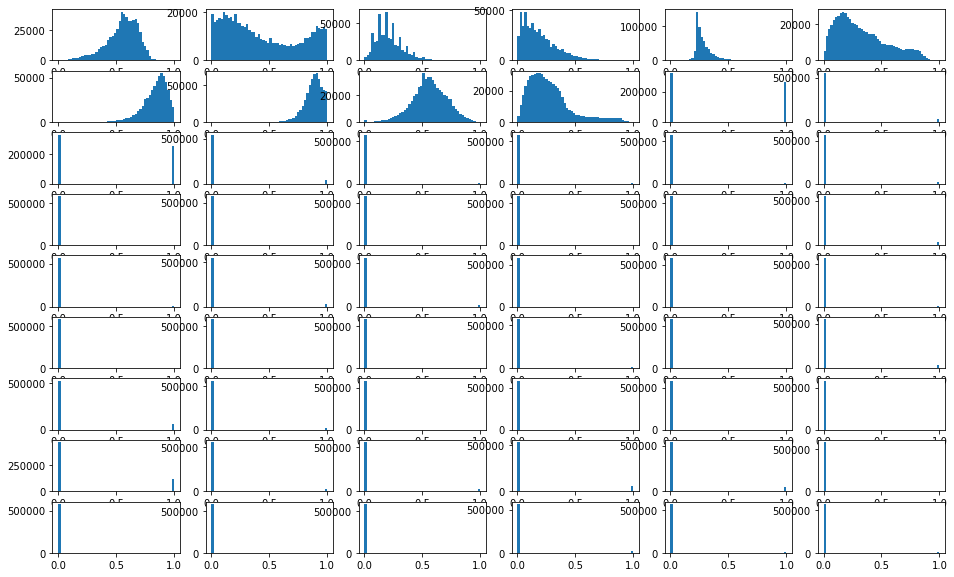

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(9, 6, figsize=(16, 10))
for i in range(54):
    axs[i // 6, i % 6].hist(X[:, i], bins=50)

plt.show()

what about mutual feature distribution?

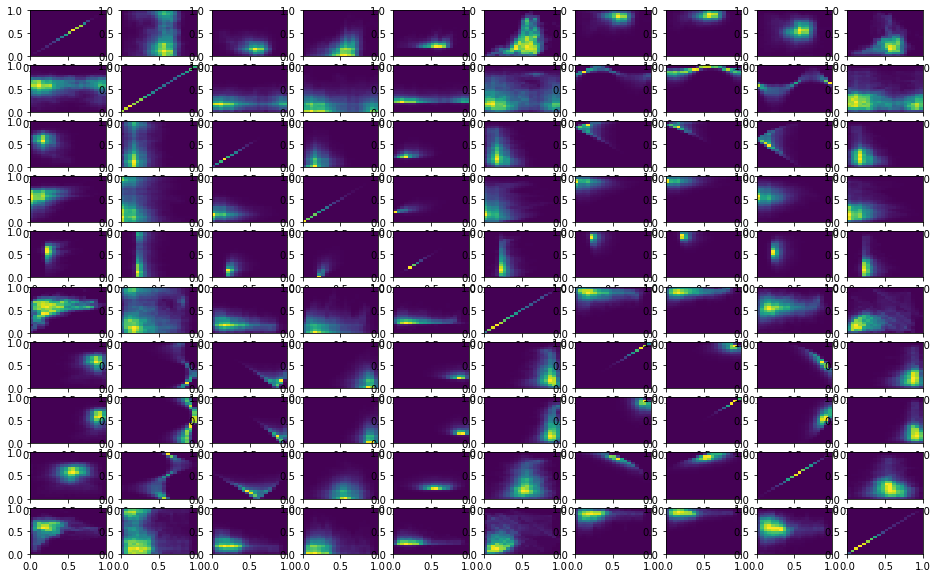

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 10, figsize=(16, 10))
for i in range(10):
    for j in range(10):
        axs[i, j].hist2d(X[:, i], X[:, j], bins=20)

plt.show()

## 2.2. Can we use histogram to generate new data?

One way: to fit some distribution first. E.g. Dirichlet.

REF: https://tminka.github.io/papers/dirichlet/

```
@InProceedings{minka2000estimating,
author = {Minka, Tom},
title = {Estimating a Dirichlet Distribution},
year = {2000},
month = {September},
abstract = {The Dirichlet distribution and its compound variant, the Dirichlet-multinomial, are two of the most basic models for proportional data, such as the mix of vocabulary words in a text document. Yet the maximum-likelihood estimate of these distributions is not available in closed-form. This paper describes simple and efficient iterative schemes for obtaining parameter estimates in these models. In each case, a fixed-point iteration and a Newton-Raphson (or generalized Newton-Raphson) iteration is provided.},
url = {https://www.microsoft.com/en-us/research/publication/estimating-dirichlet-distribution/},
}
```

But to store a multivariate distribution of 54 dimensions we will run out of memory.

Many pairs of this dataset look like independent multivariate distributions. Thus we can generate few distributions for some features and then construct a multivariate generator.

What about feature correlation and covariation?

**Correlation** -- when expected value if Y depends on X value. Can be linear. If variance of Y depends on X, this is not correlation.

**Covariation** -- when independent variables rule $E(XY) = E(X)E(Y)$ fails. $cov(X,Y) = E(XY) - E(X)E(Y)$. The bigger is absolute value, the bigger is dependency. Covariance unit is squared unit of variables. We norm it by the spread to get *linear correlation coefficient*.

If linear correlation coefficient equals to 1/-1, then we have functional dependency. If it is 0, this doesn't mean independency -- they just don't *correlate*.

In [4]:
import pandas as pd
df = pd.DataFrame(X)

In [5]:
CX = df.corr()

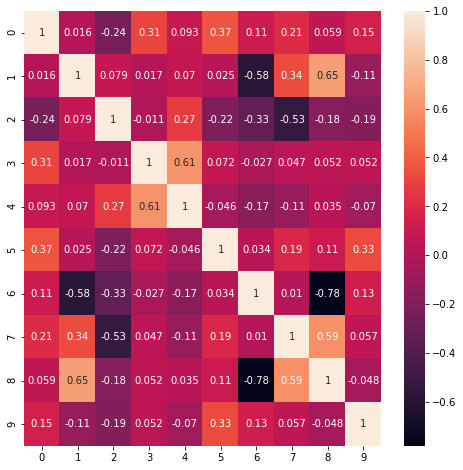

In [6]:
import seaborn as sn
import matplotlib.pyplot as plt

CXA = np.array(CX)
plt.figure(figsize=(8, 8))
sn.heatmap(CXA[:10, :10], annot=True)
plt.show()

Some pairs show non-marginal correlation. TODO: and what?

In [8]:
from sklearn.decomposition import IncrementalPCA
pca = IncrementalPCA(n_components=20)
pca.fit(X)

IncrementalPCA(batch_size=None, copy=True, n_components=20, whiten=False)

In [9]:
sum(pca.explained_variance_ratio_)

0.8800448854431941

### 2.2.1. Generate a dataset with given list of histograms

Refer to https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis

In [10]:
from scipy.stats import rv_histogram
def generate_by_hists(hists, N):
    result = np.zeros((N, len(hists)))
    for i, hist in enumerate(hists):
        distr = rv_histogram(hist)
        result[:, i] = distr.rvs(size=N)
    return result
        
np.random.seed(1234567)
hists = [np.histogram(X[:, col]) for col in range(X.shape[1])]
Xprime = generate_by_hists(hists, 10000)

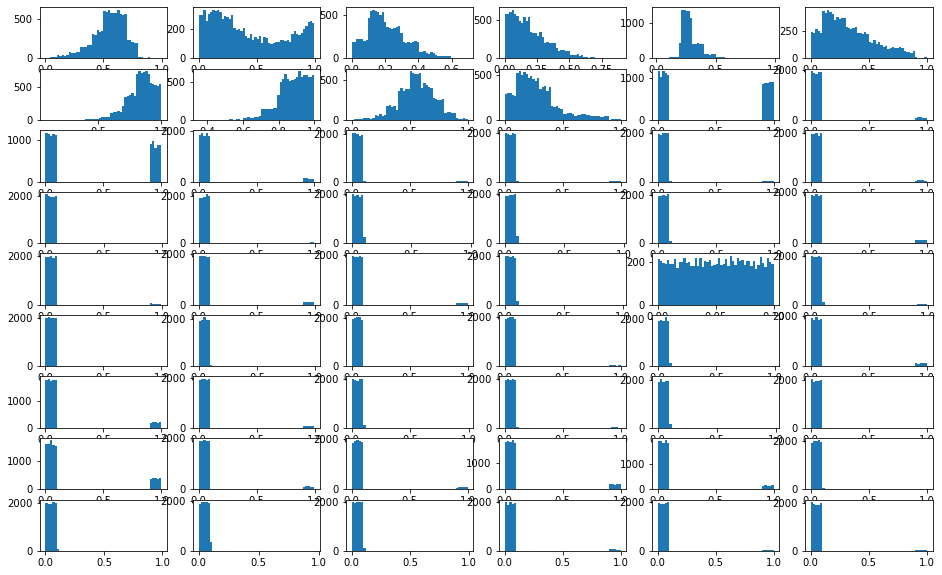

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(9, 6, figsize=(16, 10))
for i in range(54):
    axs[i // 6, i % 6].hist(Xprime[:, i], bins=50)

plt.show()

2 features feels like spoiled (just 0-s in original hist).

# 2.3. Ok, how we create a class boundary?

We need a synthetic boundary, which is allows us to easily compute distance from random point to it. Spherical is an interesting approach.

We will randomly pick groups of 2 features and for them build smooth boundaries of either spherical or linear 

In [14]:
import numpy as np
from numpy.linalg import norm

def split_dataset_linearly(X):
    # find a mean point for each axis
    M = np.mean(X, axis=0)
    # any hyperplane through this point will split the data into 2 parts exactly
    np.random.seed(0)
    K = np.random.rand(X.shape[1], 1) * 2 - 1
    # we will use (X - M) dot K to decide a class
    Xc = (X - M) @ K    
    # whatever is higher than hyperplane is 1
    classes = (Xc > 0).flatten().astype(int)
    return classes, M, K

yprime, M, K = split_dataset_linearly(X)
I = np.dot(M, K)[0] / norm(K)
sum(yprime), len(yprime) - sum(yprime)

(339595, 241417)

`K` here corresponds to decision plane coefficients. Same (but scaled) coefficients are produced by linear regression model.

`Intercept` will be a value of `Y` with `X=0`, in our case this is `(-M @ K)`.

Let's check that we created a linearly separable model

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, yprime, test_size=0.4, random_state=0)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:430: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "
C:\anaconda\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     96304
           1       0.99      1.00      0.99    136101

    accuracy                           0.99    232405
   macro avg       0.99      0.99      0.99    232405
weighted avg       0.99      0.99      0.99    232405



The report should show a linear classifier with very high accuracy value. So yes, we have a nice dataset.

In [16]:
from numpy.linalg import norm 

def signed_dist_to_plane(point, K, I):
    return np.dot(point, K)[0] / norm(K) - I

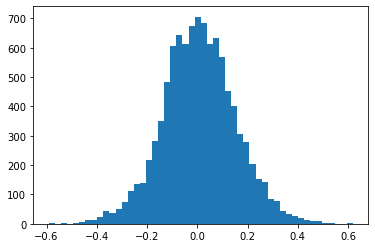

In [17]:
dst = [signed_dist_to_plane(x, K, I) for x in Xprime]
plt.hist(dst, bins=50)
plt.show()

Ok we have a generated dataset and a tool to estimate a distance from arbitrary point to it's decision boundary.

# 3. Building a proximity graph

We will build different proximity graphs for the given dataset. Our task is to measure:
- build complexity for each of them
- space complexity for graph
- quality of border estimation
- space complexity of graph cut

## 3.1. NSW

In [18]:
import sys
sys.path.append('../modules')
from nsw.nsw import Node, NSWGraph

G = NSWGraph()
data_sample = [(x, y) for x, y in zip(Xprime[:1000], yprime[:1000])]
G.build_navigable_graph(data_sample)

## 3.2. Radius NG with BAllTree

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.radius_neighbors_graph.html#sklearn.neighbors.radius_neighbors_graph

In [ ]:
from sklearn.neighbors import radius_neighbors_graph
rNG = radius_neighbors_graph(Xprime[:10000], radius=1)

In [ ]:
sum(rNG)

## 3.2. k-NN graph with BallTree
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html

In [26]:
from sklearn.neighbors import kneighbors_graph
kNN = kneighbors_graph(Xprime[:10000], n_neighbors=5)

In [27]:
sum(kNN)

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 9047 stored elements in Compressed Sparse Row format>

## 3.1. Euclidean MST (EMST)
- https://en.wikipedia.org/wiki/Euclidean_minimum_spanning_tree
- https://github.com/AndrewB330/EuclideanMST